# Load packages and libraries

In [187]:
.libPaths()
.libPaths(new = c("/home/manuel.tardaguila/conda_envs/multiome_QC_DEF/lib/R/library"))
.libPaths()
# sessionInfo()

Sys.setenv(RETICULATE_PYTHON="/home/manuel.tardaguila/conda_envs/multiome_QC_DEF/bin/python")
library(reticulate)
reticulate::use_python("/home/manuel.tardaguila/conda_envs/multiome_QC_DEF/bin/python")
reticulate::use_condaenv("/home/manuel.tardaguila/conda_envs/multiome_QC_DEF")
reticulate::py_module_available(module='leidenalg')
reticulate::import('leidenalg')
suppressMessages(library("optparse"))
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Matrix))
suppressMessages(library(data.table))
suppressMessages(library(ggpubr))
suppressMessages(library(ggplot2))
suppressMessages(library(scDblFinder))
suppressMessages(library("tidyr"))
suppressMessages(library("tibble"))
suppressMessages(library("biovizBase"))
suppressMessages(library("patchwork"))
suppressMessages(library(glmGamPoi))
suppressMessages(library(SeuratData))
suppressMessages(library(SeuratDisk))
library(svglite)
library(RColorBrewer)
library(forcats)
library(cowplot)




[1] "/home/manuel.tardaguila/conda_envs/multiome_QC_DEF/lib/R/library"

[1] "/home/manuel.tardaguila/conda_envs/multiome_QC_DEF/lib/R/library"

[1] TRUE

Module(leidenalg)

# Checkpoint with all the cells, annotated and rpca integrated

In [188]:
setwd("/scratch/manuel.tardaguila/hESC_MK_SCRNAseq_10X/no_competition/processing_outputs/")

adata<-readRDS(file="merged_unprocessed_db_filt_clustered_QCed_cell_annotated_rpca_integrate_clustered_subcluster_majority_vote.rds")

In [189]:
adata

An object of class Seurat 
104138 features across 35220 samples within 4 assays 
Active assay: SCT (28364 features, 0 variable features)
 3 layers present: counts, data, scale.data
 3 other assays present: RNA, RNA_raw, integrated
 2 dimensional reductions calculated: pca, umap

# Read targeted amplified GEX no Cell Bender

## Read each of the files in Seurat Diff1

In [190]:
 adata_samp_1                 <- CreateSeuratObject(counts=Read10X_h5(file.path("/scratch/manuel.tardaguila/hESC_MK_SCRNAseq_10X/no_competition/targeted_amplicon_GEX/MCO_01373_3GEX/outs/", 'raw_feature_bc_matrix.h5')))
  
 adata_samp_1$orig.ident<-'MCO_01373_3GEX'

adata_samp_2                 <- CreateSeuratObject(counts=Read10X_h5(file.path("/scratch/manuel.tardaguila/hESC_MK_SCRNAseq_10X/no_competition/targeted_amplicon_GEX/MCO_01374_3GEX/outs/", 'raw_feature_bc_matrix.h5')))
  
adata_samp_2$orig.ident<-'MCO_01374_3GEX'



Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


## combine them in a single object

In [191]:
adatas<-list()

adatas[[1]]<-adata_samp_1
adatas[[2]]<-adata_samp_2


sample_array<-c('MCO_01373_3GEX','MCO_01374_3GEX')

merged = merge(x =adatas[[1]], y=adatas[2], add.cell.ids = sample_array )

merged[["RNA"]] <-JoinLayers(merged[["RNA"]])

merged


An object of class Seurat 
12 features across 662043 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

## Only use the barcodes that are part of my final object

In [192]:
joint.bcs <- intersect(colnames(adata), colnames(merged))

str(joint.bcs)

 chr [1:35216] "MCO_01373_3GEX_AAACCAAAGTAGACTT-1" ...


In [193]:
merged_restricted <- subset(merged, cells = joint.bcs)

merged_restricted

An object of class Seurat 
12 features across 35216 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

In [194]:
HTO_NOCellBender_counts<-GetAssayData(
  merged_restricted,
  layer = c("counts"))+1

### Adding a pseudocount as seen in https://github.com/satijalab/seurat/issues/5640


In [195]:
str(HTO_NOCellBender_counts)

Formal class 'dgeMatrix' [package "Matrix"] with 4 slots
  ..@ Dim     : int [1:2] 12 35216
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:12] "GFP-chrGFP-WTA" "GFP-chrGFP-WTB" "GFP-chrGFP-WTC" "GFP-chrGFP-rs1" ...
  .. ..$ : chr [1:35216] "MCO_01373_3GEX_AAACCAAAGTAGACTT-1" "MCO_01373_3GEX_AAACCAAAGTCATCGA-1" "MCO_01373_3GEX_AAACCAAAGTGAACTT-1" "MCO_01373_3GEX_AAACCATTCCCAGGTG-1" ...
  ..@ x       : num [1:422592] 4 11 3 7 1 8 11 3 11 19 ...
  ..@ factors : list()


In [196]:
merged_restricted[["HTO_NOCellBender"]] <- CreateAssayObject(counts = HTO_NOCellBender_counts)

In [197]:
merged_restricted

An object of class Seurat 
24 features across 35216 samples within 2 assays 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts
 1 other assay present: HTO_NOCellBender

## normalize CLR

In [198]:
merged_restricted <- NormalizeData(merged_restricted, assay = "HTO_NOCellBender", normalization.method = "CLR")


Normalizing across features



## Demultiplex using HTO Demux

In [199]:
merged_restricted <- HTODemux(merged_restricted, assay = "HTO_NOCellBender", positive.quantile = 0.99)


Cutoff for GFP-chrGFP-WTA : 10 reads

Cutoff for GFP-chrGFP-WTB : 29 reads

Cutoff for GFP-chrGFP-WTC : 15 reads

Cutoff for GFP-chrGFP-rs1 : 23 reads

Cutoff for GFP-chrGFP-rs2 : 6 reads

Cutoff for GFP-chrGFP-rs3 : 39 reads

Cutoff for GFP-chrGFP-R882H1 : 33 reads

Cutoff for GFP-chrGFP-R882H2 : 5 reads

Cutoff for GFP-chrGFP-R882H3 : 23 reads

Cutoff for GFP-chrGFP-rs-R882H1 : 26 reads

Cutoff for GFP-chrGFP-rs-R882H2 : 6 reads

Cutoff for GFP-chrGFP-rs-R882H3 : 31 reads



In [200]:
str(merged_restricted@meta.data)

'data.frame':	35216 obs. of  11 variables:
 $ orig.ident                            : chr  "MCO_01373_3GEX" "MCO_01373_3GEX" "MCO_01373_3GEX" "MCO_01373_3GEX" ...
 $ nCount_RNA                            : num  77 333 120 340 247 342 62 50 464 82 ...
 $ nFeature_RNA                          : int  11 12 12 12 12 12 12 10 12 11 ...
 $ nCount_HTO_NOCellBender               : num  89 345 132 352 259 354 74 62 476 94 ...
 $ nFeature_HTO_NOCellBender             : int  12 12 12 12 12 12 12 12 12 12 ...
 $ HTO_NOCellBender_maxID                : chr  "GFP-chrGFP-R882H2" "GFP-chrGFP-WTB" "GFP-chrGFP-rs2" "GFP-chrGFP-R882H1" ...
 $ HTO_NOCellBender_secondID             : chr  "GFP-chrGFP-rs-R882H1" "GFP-chrGFP-R882H2" "GFP-chrGFP-rs-R882H2" "GFP-chrGFP-rs-R882H2" ...
 $ HTO_NOCellBender_margin               : num  0.0784 0.4822 0.2661 0.2626 0.2262 ...
 $ HTO_NOCellBender_classification       : chr  "Negative" "GFP-chrGFP-R882H2_GFP-chrGFP-WTB" "Negative" "GFP-chrGFP-R882H1_GFP-chrGFP-rs-R882H

In [201]:
summary(merged_restricted@meta.data$hash.ID)

Doublet             Negative       GFP-chrGFP-WTA 
               29637                 3037                  135 
   GFP-chrGFP-R882H3       GFP-chrGFP-rs3       GFP-chrGFP-rs2 
                 212                  262                   58 
   GFP-chrGFP-R882H2 GFP-chrGFP-rs-R882H2       GFP-chrGFP-rs1 
                  70                   68                  278 
      GFP-chrGFP-WTB GFP-chrGFP-rs-R882H1       GFP-chrGFP-WTC 
                 254                  278                  187 
GFP-chrGFP-rs-R882H3    GFP-chrGFP-R882H1 
                 287                  453

In [202]:
table(merged_restricted$HTO_NOCellBender_classification.global)


 Doublet Negative  Singlet 
   29637     3037     2542 

In [203]:
# Group cells based on the max HTO_NOCellBender signal
Idents(merged_restricted) <- "HTO_NOCellBender_maxID"
rp1<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[1], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp2<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[2], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp3<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[3], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp4<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[4], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

##

rp5<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[5], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp6<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[6], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp7<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[7], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp8<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[8], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

##

rp9<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[9], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp10<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[10], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp11<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[11], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp12<-RidgePlot(merged_restricted, assay = "HTO_NOCellBender", features = rownames(merged_restricted[["HTO_NOCellBender"]])[12], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

In [204]:
path_Genotyping<-"/group/soranzo/manuel.tardaguila/2025_hESC_MK_SCRNAseq_10X/no_competition/Genotyping/"

In [205]:
if (file.exists(path_Genotyping)){

    }else{

    dir.create(path_Genotyping)
    }

In [206]:
path_graphs<-paste(path_Genotyping,"graphs/",sep='')

In [207]:
if (file.exists(path_graphs)){

    }else{

    dir.create(path_graphs)
    }

In [208]:
setwd(path_graphs)
png(file='Ridgeplot_assignation_WTs_NO_CellBender.png', width =1050, height = 350)
rp1 | rp2 | rp3
dev.off()

Picking joint bandwidth of 0.0483

Picking joint bandwidth of 0.0456

Picking joint bandwidth of 0.0473



png 
  2

In [209]:
setwd(path_graphs)
png(file='Ridgeplot_assignation_rs_NO_CellBender.png', width =1050, height = 350)
rp4 | rp5 | rp6
dev.off()

Picking joint bandwidth of 0.0445

Picking joint bandwidth of 0.0749

Picking joint bandwidth of 0.0475



png 
  2

In [210]:
setwd(path_graphs)
png(file='Ridgeplot_assignation_DNMT3A_NO_CellBender.png', width =1050, height = 350)
rp7 | rp8 | rp9
dev.off()

Picking joint bandwidth of 0.045

Picking joint bandwidth of 0.0842

Picking joint bandwidth of 0.0653



png 
  2

In [211]:
setwd(path_graphs)
png(file='Ridgeplot_assignation_Double_mutants_NO_CellBender.png', width =1050, height = 350)
rp10 | rp11 | rp12
dev.off()

Picking joint bandwidth of 0.0463

Picking joint bandwidth of 0.0816

Picking joint bandwidth of 0.0443



png 
  2

### Save this assignation

In [212]:
colnames(merged_restricted@meta.data)


str(row.names(merged_restricted@meta.data))

[1] "orig.ident"                            
 [2] "nCount_RNA"                            
 [3] "nFeature_RNA"                          
 [4] "nCount_HTO_NOCellBender"               
 [5] "nFeature_HTO_NOCellBender"             
 [6] "HTO_NOCellBender_maxID"                
 [7] "HTO_NOCellBender_secondID"             
 [8] "HTO_NOCellBender_margin"               
 [9] "HTO_NOCellBender_classification"       
[10] "HTO_NOCellBender_classification.global"
[11] "hash.ID"

 chr [1:35216] "MCO_01373_3GEX_AAACCAAAGTAGACTT-1" ...


In [213]:
path_save<-"/scratch/manuel.tardaguila/hESC_MK_SCRNAseq_10X/no_competition/targeted_amplicon_GEX/processing_outputs/"

In [214]:
setwd(path_save)

write.csv(merged_restricted@meta.data,"NO_CellBender_Barcodes_demux_assignation.csv")

## Add new Genotype Annotation to adata

In [215]:
colnames(adata@meta.data)

[1] "orig.ident"                          
 [2] "nCount_RNA"                          
 [3] "nFeature_RNA"                        
 [4] "nCount_RNA_raw"                      
 [5] "nFeature_RNA_raw"                    
 [6] "percent.mt"                          
 [7] "scDblFinder.class"                   
 [8] "scDblFinder.score"                   
 [9] "scDblFinder.weighted"                
[10] "scDblFinder.cxds_score"              
[11] "Diff"                                
[12] "nCount_SCT"                          
[13] "nFeature_SCT"                        
[14] "SCT_snn_res.2"                       
[15] "seurat_clusters"                     
[16] "SCT_snn_res.0.5"                     
[17] "CellTypist_label_Alsinet"            
[18] "CellTypist_conf_score_Alsinet"       
[19] "CellTypist_label_FBMA"               
[20] "CellTypist_conf_score_FBMA"          
[21] "CellTypist_label_Immune_ALL_low"     
[22] "CellTypist_conf_score_Immune_ALL_low"
[23] "Integrated_annotation"               
[24] "integrated_nn_res.0.5"               
[25] "Subclusters_2"                       
[26] "Subclusters_5"                       
[27] "Subclusters_7"                       
[28] "Subclusters_9"                       
[29] "Subclusters_10"                      
[30] "Subclusters_11"                      
[31] "Subclusters_13"                      
[32] "my_own_clusters"                     
[33] "Integrated_annotation_after_rpca"

### Eliminate residual Assigned_GFPbc from GEX not amplified libraries

In [216]:
adata@meta.data$Assigned_GFPbc<-NA

In [217]:
adata<-AddMetaData(object= adata,
                  metadata= merged_restricted@meta.data$hash.ID,
                  col.name = "Assignation_demux_NO_CellBender")

In [218]:
summary(as.factor(adata@meta.data$Assignation_demux_NO_CellBender))

Doublet             Negative       GFP-chrGFP-WTA 
               29639                 3039                  135 
   GFP-chrGFP-R882H3       GFP-chrGFP-rs3       GFP-chrGFP-rs2 
                 212                  262                   58 
   GFP-chrGFP-R882H2 GFP-chrGFP-rs-R882H2       GFP-chrGFP-rs1 
                  70                   68                  278 
      GFP-chrGFP-WTB GFP-chrGFP-rs-R882H1       GFP-chrGFP-WTC 
                 254                  278                  187 
GFP-chrGFP-rs-R882H3    GFP-chrGFP-R882H1 
                 287                  453

In [219]:
adata@meta.data$Assigned_GFPbc_demux__NO_CellBender<-gsub("^GFP-","",adata@meta.data$Assignation_demux_NO_CellBender)

In [220]:
adata@meta.data$Assigned_GFPbc_demux__NO_CellBender<-gsub("-","_",adata@meta.data$Assigned_GFPbc_demux__NO_CellBender)

In [221]:
summary(as.factor(adata@meta.data$Assigned_GFPbc_demux__NO_CellBender))

chrGFP_R882H1    chrGFP_R882H2    chrGFP_R882H3 chrGFP_rs_R882H1 
             453               70              212              278 
chrGFP_rs_R882H2 chrGFP_rs_R882H3       chrGFP_rs1       chrGFP_rs2 
              68              287              278               58 
      chrGFP_rs3       chrGFP_WTA       chrGFP_WTB       chrGFP_WTC 
             262              135              254              187 
         Doublet         Negative 
           29639             3039

In [222]:
adata@meta.data$Assigned_GFPbc_demux__NO_CellBender<-factor(adata@meta.data$Assigned_GFPbc_demux__NO_CellBender,
                                       levels = c("chrGFP_WTA","chrGFP_WTB","chrGFP_WTC",
                                                  "chrGFP_rs1","chrGFP_rs2","chrGFP_rs3",
                                                  "chrGFP_R882H1","chrGFP_R882H2","chrGFP_R882H3",
                                                  "chrGFP_rs_R882H1","chrGFP_rs_R882H2","chrGFP_rs_R882H3","Doublet","Negative"),
                                       ordered=T)

In [223]:
summary(adata@meta.data$Assigned_GFPbc_demux__NO_CellBender)

chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
             135              254              187              278 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
              58              262              453               70 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
             212              278               68              287 
         Doublet         Negative 
           29639             3039

In [224]:
colnames(adata@meta.data)

[1] "orig.ident"                          
 [2] "nCount_RNA"                          
 [3] "nFeature_RNA"                        
 [4] "nCount_RNA_raw"                      
 [5] "nFeature_RNA_raw"                    
 [6] "percent.mt"                          
 [7] "scDblFinder.class"                   
 [8] "scDblFinder.score"                   
 [9] "scDblFinder.weighted"                
[10] "scDblFinder.cxds_score"              
[11] "Diff"                                
[12] "nCount_SCT"                          
[13] "nFeature_SCT"                        
[14] "SCT_snn_res.2"                       
[15] "seurat_clusters"                     
[16] "SCT_snn_res.0.5"                     
[17] "CellTypist_label_Alsinet"            
[18] "CellTypist_conf_score_Alsinet"       
[19] "CellTypist_label_FBMA"               
[20] "CellTypist_conf_score_FBMA"          
[21] "CellTypist_label_Immune_ALL_low"     
[22] "CellTypist_conf_score_Immune_ALL_low"
[23] "Integrated_annotation"               
[24] "integrated_nn_res.0.5"               
[25] "Subclusters_2"                       
[26] "Subclusters_5"                       
[27] "Subclusters_7"                       
[28] "Subclusters_9"                       
[29] "Subclusters_10"                      
[30] "Subclusters_11"                      
[31] "Subclusters_13"                      
[32] "my_own_clusters"                     
[33] "Integrated_annotation_after_rpca"    
[34] "Assigned_GFPbc"                      
[35] "Assignation_demux_NO_CellBender"     
[36] "Assigned_GFPbc_demux__NO_CellBender"

# Read targeted amplified GEX with Cell Bender correction

## From diff 1

In [225]:
cb_counts = Read10X_h5(file.path("/scratch/manuel.tardaguila/hESC_MK_SCRNAseq_10X/no_competition/targeted_amplicon_GEX/processing_outputs/MCO_01373_3GEX/", 'cellbender_gex_seurat.h5'))

adata_samp_1_CellBender = CreateSeuratObject(counts = cb_counts)
adata_samp_1_CellBender$orig.ident<-'MCO_01373_3GEX'

cb_counts = Read10X_h5(file.path("/scratch/manuel.tardaguila/hESC_MK_SCRNAseq_10X/no_competition/targeted_amplicon_GEX/processing_outputs/MCO_01374_3GEX/", 'cellbender_gex_seurat.h5'))

adata_samp_2_CellBender = CreateSeuratObject(counts = cb_counts)
adata_samp_2_CellBender$orig.ident<-'MCO_01374_3GEX'



Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


## combine them in a single object

In [226]:
adatas<-list()

adatas[[1]]<-adata_samp_1_CellBender
adatas[[2]]<-adata_samp_2_CellBender


sample_array<-c('MCO_01373_3GEX','MCO_01374_3GEX')

merged_CellBender = merge(x =adatas[[1]], y=adatas[2], add.cell.ids = sample_array )

merged_CellBender[["RNA"]] <-JoinLayers(merged_CellBender[["RNA"]])

merged_CellBender


An object of class Seurat 
12 features across 662043 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

## Only use the barcodes that are part of my final object

In [227]:
joint.bcs <- intersect(colnames(adata), colnames(merged_CellBender))

str(joint.bcs)

 chr [1:35216] "MCO_01373_3GEX_AAACCAAAGTAGACTT-1" ...


In [228]:
merged_CellBender_restricted <- subset(merged_CellBender, cells = joint.bcs)

merged_CellBender_restricted

An object of class Seurat 
12 features across 35216 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

In [229]:
hto_CellBender_counts<-GetAssayData(
  merged_CellBender_restricted,
  layer = c("counts"))+1

### Adding a pseudocount as seen in https://github.com/satijalab/seurat/issues/5640


In [230]:
str(hto_CellBender_counts)

Formal class 'dgeMatrix' [package "Matrix"] with 4 slots
  ..@ Dim     : int [1:2] 12 35216
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:12] "GFP-chrGFP-WTA" "GFP-chrGFP-WTB" "GFP-chrGFP-WTC" "GFP-chrGFP-rs1" ...
  .. ..$ : chr [1:35216] "MCO_01373_3GEX_AAACCAAAGTAGACTT-1" "MCO_01373_3GEX_AAACCAAAGTCATCGA-1" "MCO_01373_3GEX_AAACCAAAGTGAACTT-1" "MCO_01373_3GEX_AAACCATTCCCAGGTG-1" ...
  ..@ x       : num [1:422592] 3 9 3 6 1 7 10 2 9 17 ...
  ..@ factors : list()


In [231]:
merged_CellBender_restricted[["HTO_CellBender"]] <- CreateAssayObject(counts = hto_CellBender_counts)

In [232]:
merged_CellBender_restricted

An object of class Seurat 
24 features across 35216 samples within 2 assays 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts
 1 other assay present: HTO_CellBender

## normalize CLR

In [233]:
merged_CellBender_restricted <- NormalizeData(merged_CellBender_restricted, assay = "HTO_CellBender", normalization.method = "CLR")


Normalizing across features



## Demultiplex using HTO Demux

In [234]:
merged_CellBender_restricted <- HTODemux(merged_CellBender_restricted, assay = "HTO_CellBender", positive.quantile = 0.99)


Cutoff for GFP-chrGFP-WTA : 5 reads

Cutoff for GFP-chrGFP-WTB : 16 reads

Cutoff for GFP-chrGFP-WTC : 8 reads

Cutoff for GFP-chrGFP-rs1 : 12 reads

Cutoff for GFP-chrGFP-rs2 : 4 reads

Cutoff for GFP-chrGFP-rs3 : 22 reads

Cutoff for GFP-chrGFP-R882H1 : 17 reads

Cutoff for GFP-chrGFP-R882H2 : 4 reads

Cutoff for GFP-chrGFP-R882H3 : 12 reads

Cutoff for GFP-chrGFP-rs-R882H1 : 13 reads

Cutoff for GFP-chrGFP-rs-R882H2 : 4 reads

Cutoff for GFP-chrGFP-rs-R882H3 : 17 reads



In [235]:
summary(merged_CellBender_restricted@meta.data$hash.ID)

Doublet GFP-chrGFP-rs-R882H1       GFP-chrGFP-WTA 
               31902                   95                   47 
            Negative    GFP-chrGFP-R882H2    GFP-chrGFP-R882H3 
                2285                   51                   86 
      GFP-chrGFP-WTB    GFP-chrGFP-R882H1       GFP-chrGFP-rs1 
                 120                  105                  149 
      GFP-chrGFP-WTC GFP-chrGFP-rs-R882H2       GFP-chrGFP-rs3 
                  75                   45                  138 
      GFP-chrGFP-rs2 GFP-chrGFP-rs-R882H3 
                  30                   88

## Add CellBender Demux to Genotype Annotation to adata

In [236]:
adata<-AddMetaData(object= adata,
                  metadata= merged_CellBender_restricted@meta.data$hash.ID,
                  col.name = "Assignation_demux_CellBender")

In [237]:
summary(as.factor(adata@meta.data$Assignation_demux_CellBender))

Doublet GFP-chrGFP-rs-R882H1       GFP-chrGFP-WTA 
               31905                   96                   47 
            Negative    GFP-chrGFP-R882H2    GFP-chrGFP-R882H3 
                2285                   51                   86 
      GFP-chrGFP-WTB    GFP-chrGFP-R882H1       GFP-chrGFP-rs1 
                 120                  105                  149 
      GFP-chrGFP-WTC GFP-chrGFP-rs-R882H2       GFP-chrGFP-rs3 
                  75                   45                  138 
      GFP-chrGFP-rs2 GFP-chrGFP-rs-R882H3 
                  30                   88

In [238]:
adata@meta.data$Assigned_GFPbc_demux_CellBender<-gsub("^GFP-","",adata@meta.data$Assignation_demux_CellBender)

In [239]:
adata@meta.data$Assigned_GFPbc_demux_CellBender<-gsub("-","_",adata@meta.data$Assigned_GFPbc_demux_CellBender)

In [240]:
summary(as.factor(adata@meta.data$Assigned_GFPbc_demux_CellBender))

chrGFP_R882H1    chrGFP_R882H2    chrGFP_R882H3 chrGFP_rs_R882H1 
             105               51               86               96 
chrGFP_rs_R882H2 chrGFP_rs_R882H3       chrGFP_rs1       chrGFP_rs2 
              45               88              149               30 
      chrGFP_rs3       chrGFP_WTA       chrGFP_WTB       chrGFP_WTC 
             138               47              120               75 
         Doublet         Negative 
           31905             2285

In [241]:
adata@meta.data$Assigned_GFPbc_demux_CellBender<-factor(adata@meta.data$Assigned_GFPbc_demux_CellBender,
                                       levels = c("chrGFP_WTA","chrGFP_WTB","chrGFP_WTC",
                                                  "chrGFP_rs1","chrGFP_rs2","chrGFP_rs3",
                                                  "chrGFP_R882H1","chrGFP_R882H2","chrGFP_R882H3",
                                                  "chrGFP_rs_R882H1","chrGFP_rs_R882H2","chrGFP_rs_R882H3","Doublet","Negative"),
                                       ordered=T)

In [242]:
summary(adata@meta.data$Assigned_GFPbc_demux_CellBender)

chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
              47              120               75              149 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
              30              138              105               51 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
              86               96               45               88 
         Doublet         Negative 
           31905             2285

### Save this assignation

In [243]:
colnames(merged_CellBender_restricted@meta.data)


str(row.names(merged_CellBender_restricted@meta.data))

[1] "orig.ident"                          
 [2] "nCount_RNA"                          
 [3] "nFeature_RNA"                        
 [4] "nCount_HTO_CellBender"               
 [5] "nFeature_HTO_CellBender"             
 [6] "HTO_CellBender_maxID"                
 [7] "HTO_CellBender_secondID"             
 [8] "HTO_CellBender_margin"               
 [9] "HTO_CellBender_classification"       
[10] "HTO_CellBender_classification.global"
[11] "hash.ID"

 chr [1:35216] "MCO_01373_3GEX_AAACCAAAGTAGACTT-1" ...


In [244]:
path_save<-"/scratch/manuel.tardaguila/hESC_MK_SCRNAseq_10X/no_competition/targeted_amplicon_GEX/processing_outputs/"

In [245]:
setwd(path_save)

write.csv(merged_CellBender_restricted@meta.data,"CellBender_Barcodes_demux_assignation.csv")

# Add genotyping from GEX not amplified alignment

## Diff1

In [246]:
diff1<-readRDS(file="/group/soranzo/manuel.tardaguila/2025_hESC_MK_SCRNAseq_10X/no_competition/count_and_filter/Uniquely_genotyped_and_filtered_larry_barcodes_assignments.rds")

str(diff1)

'data.frame':	37306 obs. of  5 variables:
 $ sample           : Ord.factor w/ 2 levels "MCO_01373_3GEX"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ CellBC           : chr  "CB:Z:AAACCATTCGCTGGCA-1" "CB:Z:AAACCGCTCTCATGTC-1" "CB:Z:AAACGACAGTTGGGCT-1" "CB:Z:AAACGCCTCGCGATTA-1" ...
 $ GFPbc            : Ord.factor w/ 13 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ GFPbc_attribution: int  1 1 1 1 1 1 1 1 1 1 ...
 $ Number_of_UMIS   : int  6 32 12 30 28 33 33 28 37 4 ...


In [247]:
df<-diff1


str(df)

'data.frame':	37306 obs. of  5 variables:
 $ sample           : Ord.factor w/ 2 levels "MCO_01373_3GEX"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ CellBC           : chr  "CB:Z:AAACCATTCGCTGGCA-1" "CB:Z:AAACCGCTCTCATGTC-1" "CB:Z:AAACGACAGTTGGGCT-1" "CB:Z:AAACGCCTCGCGATTA-1" ...
 $ GFPbc            : Ord.factor w/ 13 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ GFPbc_attribution: int  1 1 1 1 1 1 1 1 1 1 ...
 $ Number_of_UMIS   : int  6 32 12 30 28 33 33 28 37 4 ...


In [248]:
# desired format MCO_01373_3GEX_AAACAGCCACAGCCAT-1

df$CellID<-paste(df$sample,gsub("^[^:]+:[^:]+:","", df$CellBC),sep="_")

str(df)


'data.frame':	37306 obs. of  6 variables:
 $ sample           : Ord.factor w/ 2 levels "MCO_01373_3GEX"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ CellBC           : chr  "CB:Z:AAACCATTCGCTGGCA-1" "CB:Z:AAACCGCTCTCATGTC-1" "CB:Z:AAACGACAGTTGGGCT-1" "CB:Z:AAACGCCTCGCGATTA-1" ...
 $ GFPbc            : Ord.factor w/ 13 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ GFPbc_attribution: int  1 1 1 1 1 1 1 1 1 1 ...
 $ Number_of_UMIS   : int  6 32 12 30 28 33 33 28 37 4 ...
 $ CellID           : chr  "MCO_01373_3GEX_AAACCATTCGCTGGCA-1" "MCO_01373_3GEX_AAACCGCTCTCATGTC-1" "MCO_01373_3GEX_AAACGACAGTTGGGCT-1" "MCO_01373_3GEX_AAACGCCTCGCGATTA-1" ...


## Filter to 3 UMIs

In [249]:
df_thresholded<-df[which(df$Number_of_UMIS >= 3 & df$GFPbc_attribution == 1),]

str(df_thresholded)

'data.frame':	37306 obs. of  6 variables:
 $ sample           : Ord.factor w/ 2 levels "MCO_01373_3GEX"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ CellBC           : chr  "CB:Z:AAACCATTCGCTGGCA-1" "CB:Z:AAACCGCTCTCATGTC-1" "CB:Z:AAACGACAGTTGGGCT-1" "CB:Z:AAACGCCTCGCGATTA-1" ...
 $ GFPbc            : Ord.factor w/ 13 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ GFPbc_attribution: int  1 1 1 1 1 1 1 1 1 1 ...
 $ Number_of_UMIS   : int  6 32 12 30 28 33 33 28 37 4 ...
 $ CellID           : chr  "MCO_01373_3GEX_AAACCATTCGCTGGCA-1" "MCO_01373_3GEX_AAACCGCTCTCATGTC-1" "MCO_01373_3GEX_AAACGACAGTTGGGCT-1" "MCO_01373_3GEX_AAACGCCTCGCGATTA-1" ...


In [250]:
row.names(df_thresholded)<-df_thresholded$CellID

In [251]:
dim(df_thresholded)[1]

str(row.names(df_thresholded))

[1] 37306

 chr [1:37306] "MCO_01373_3GEX_AAACCATTCGCTGGCA-1" ...


In [252]:
summary(as.factor(df_thresholded$GFPbc))

chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
            1561             4545             2292             3510 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
             418             5635             5862              365 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
            3225             4116              478             5022 
       No_GFPbcs 
             277

## Add df_thresholded$GFPbc to adata

In [253]:
colnames(adata@meta.data)

[1] "orig.ident"                          
 [2] "nCount_RNA"                          
 [3] "nFeature_RNA"                        
 [4] "nCount_RNA_raw"                      
 [5] "nFeature_RNA_raw"                    
 [6] "percent.mt"                          
 [7] "scDblFinder.class"                   
 [8] "scDblFinder.score"                   
 [9] "scDblFinder.weighted"                
[10] "scDblFinder.cxds_score"              
[11] "Diff"                                
[12] "nCount_SCT"                          
[13] "nFeature_SCT"                        
[14] "SCT_snn_res.2"                       
[15] "seurat_clusters"                     
[16] "SCT_snn_res.0.5"                     
[17] "CellTypist_label_Alsinet"            
[18] "CellTypist_conf_score_Alsinet"       
[19] "CellTypist_label_FBMA"               
[20] "CellTypist_conf_score_FBMA"          
[21] "CellTypist_label_Immune_ALL_low"     
[22] "CellTypist_conf_score_Immune_ALL_low"
[23] "Integrated_annotation"               
[24] "integrated_nn_res.0.5"               
[25] "Subclusters_2"                       
[26] "Subclusters_5"                       
[27] "Subclusters_7"                       
[28] "Subclusters_9"                       
[29] "Subclusters_10"                      
[30] "Subclusters_11"                      
[31] "Subclusters_13"                      
[32] "my_own_clusters"                     
[33] "Integrated_annotation_after_rpca"    
[34] "Assigned_GFPbc"                      
[35] "Assignation_demux_NO_CellBender"     
[36] "Assigned_GFPbc_demux__NO_CellBender" 
[37] "Assignation_demux_CellBender"        
[38] "Assigned_GFPbc_demux_CellBender"

In [254]:
# Remove the specified column from the metadata
adata@meta.data <- adata@meta.data[, !names(adata@meta.data) %in% c('No_assigned_GFPbc','Assigned_GFPbc','Assigned_GFPgenotype','Assignation_GEX_not_amplified')]

In [255]:
colnames(adata@meta.data)

[1] "orig.ident"                          
 [2] "nCount_RNA"                          
 [3] "nFeature_RNA"                        
 [4] "nCount_RNA_raw"                      
 [5] "nFeature_RNA_raw"                    
 [6] "percent.mt"                          
 [7] "scDblFinder.class"                   
 [8] "scDblFinder.score"                   
 [9] "scDblFinder.weighted"                
[10] "scDblFinder.cxds_score"              
[11] "Diff"                                
[12] "nCount_SCT"                          
[13] "nFeature_SCT"                        
[14] "SCT_snn_res.2"                       
[15] "seurat_clusters"                     
[16] "SCT_snn_res.0.5"                     
[17] "CellTypist_label_Alsinet"            
[18] "CellTypist_conf_score_Alsinet"       
[19] "CellTypist_label_FBMA"               
[20] "CellTypist_conf_score_FBMA"          
[21] "CellTypist_label_Immune_ALL_low"     
[22] "CellTypist_conf_score_Immune_ALL_low"
[23] "Integrated_annotation"               
[24] "integrated_nn_res.0.5"               
[25] "Subclusters_2"                       
[26] "Subclusters_5"                       
[27] "Subclusters_7"                       
[28] "Subclusters_9"                       
[29] "Subclusters_10"                      
[30] "Subclusters_11"                      
[31] "Subclusters_13"                      
[32] "my_own_clusters"                     
[33] "Integrated_annotation_after_rpca"    
[34] "Assignation_demux_NO_CellBender"     
[35] "Assigned_GFPbc_demux__NO_CellBender" 
[36] "Assignation_demux_CellBender"        
[37] "Assigned_GFPbc_demux_CellBender"

In [256]:
str(df_thresholded)
summary(as.factor(df_thresholded$GFPbc))

'data.frame':	37306 obs. of  6 variables:
 $ sample           : Ord.factor w/ 2 levels "MCO_01373_3GEX"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ CellBC           : chr  "CB:Z:AAACCATTCGCTGGCA-1" "CB:Z:AAACCGCTCTCATGTC-1" "CB:Z:AAACGACAGTTGGGCT-1" "CB:Z:AAACGCCTCGCGATTA-1" ...
 $ GFPbc            : Ord.factor w/ 13 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ GFPbc_attribution: int  1 1 1 1 1 1 1 1 1 1 ...
 $ Number_of_UMIS   : int  6 32 12 30 28 33 33 28 37 4 ...
 $ CellID           : chr  "MCO_01373_3GEX_AAACCATTCGCTGGCA-1" "MCO_01373_3GEX_AAACCGCTCTCATGTC-1" "MCO_01373_3GEX_AAACGACAGTTGGGCT-1" "MCO_01373_3GEX_AAACGCCTCGCGATTA-1" ...


chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
            1561             4545             2292             3510 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
             418             5635             5862              365 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
            3225             4116              478             5022 
       No_GFPbcs 
             277

In [257]:
adata@meta.data$Assignation_GEX_not_amplified<-NA

In [258]:
gfp1      = setNames(as.character(df_thresholded$GFPbc), 
                       df_thresholded$CellID)
  
  cat("gfp1_0\n")
  cat(str(gfp1))
  cat("\n")

gfp1_0
 Named chr [1:37306] "chrGFP_WTA" "chrGFP_WTA" "chrGFP_WTA" "chrGFP_WTA" ...
 - attr(*, "names")= chr [1:37306] "MCO_01373_3GEX_AAACCATTCGCTGGCA-1" "MCO_01373_3GEX_AAACCGCTCTCATGTC-1" "MCO_01373_3GEX_AAACGACAGTTGGGCT-1" "MCO_01373_3GEX_AAACGCCTCGCGATTA-1" ...



In [259]:
adata@meta.data$Assignation_GEX_not_amplified = gfp1[rownames(adata@meta.data)]


In [260]:
summary(as.factor(adata@meta.data$Assignation_GEX_not_amplified))

chrGFP_R882H1    chrGFP_R882H2    chrGFP_R882H3 chrGFP_rs_R882H1 
            4847              271             2619             3404 
chrGFP_rs_R882H2 chrGFP_rs_R882H3       chrGFP_rs1       chrGFP_rs2 
             379             4141             3001              342 
      chrGFP_rs3       chrGFP_WTA       chrGFP_WTB       chrGFP_WTC 
            4577             1294             3683             1864 
            NA's 
            4798

In [261]:
adata@meta.data$Assignation_GEX_not_amplified<-factor(adata@meta.data$Assignation_GEX_not_amplified,
                                       levels = c("chrGFP_WTA","chrGFP_WTB","chrGFP_WTC",
                                                  "chrGFP_rs1","chrGFP_rs2","chrGFP_rs3",
                                                  "chrGFP_R882H1","chrGFP_R882H2","chrGFP_R882H3",
                                                  "chrGFP_rs_R882H1","chrGFP_rs_R882H2","chrGFP_rs_R882H3","Doublet","Negative"),
                                       ordered=T)

In [262]:
summary(as.factor(adata@meta.data$Assignation_GEX_not_amplified))

chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
            1294             3683             1864             3001 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
             342             4577             4847              271 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
            2619             3404              379             4141 
         Doublet         Negative             NA's 
               0                0             4798

In [263]:
colnames(adata@meta.data)

[1] "orig.ident"                          
 [2] "nCount_RNA"                          
 [3] "nFeature_RNA"                        
 [4] "nCount_RNA_raw"                      
 [5] "nFeature_RNA_raw"                    
 [6] "percent.mt"                          
 [7] "scDblFinder.class"                   
 [8] "scDblFinder.score"                   
 [9] "scDblFinder.weighted"                
[10] "scDblFinder.cxds_score"              
[11] "Diff"                                
[12] "nCount_SCT"                          
[13] "nFeature_SCT"                        
[14] "SCT_snn_res.2"                       
[15] "seurat_clusters"                     
[16] "SCT_snn_res.0.5"                     
[17] "CellTypist_label_Alsinet"            
[18] "CellTypist_conf_score_Alsinet"       
[19] "CellTypist_label_FBMA"               
[20] "CellTypist_conf_score_FBMA"          
[21] "CellTypist_label_Immune_ALL_low"     
[22] "CellTypist_conf_score_Immune_ALL_low"
[23] "Integrated_annotation"               
[24] "integrated_nn_res.0.5"               
[25] "Subclusters_2"                       
[26] "Subclusters_5"                       
[27] "Subclusters_7"                       
[28] "Subclusters_9"                       
[29] "Subclusters_10"                      
[30] "Subclusters_11"                      
[31] "Subclusters_13"                      
[32] "my_own_clusters"                     
[33] "Integrated_annotation_after_rpca"    
[34] "Assignation_demux_NO_CellBender"     
[35] "Assigned_GFPbc_demux__NO_CellBender" 
[36] "Assignation_demux_CellBender"        
[37] "Assigned_GFPbc_demux_CellBender"     
[38] "Assignation_GEX_not_amplified"

# Add time_point and factor diff and Integrated_annotation_after_rpca

In [264]:
adata@meta.data$time_point<-NA

In [265]:
summary(as.factor(adata@meta.data$orig.ident))

MCO_01373_3GEX MCO_01374_3GEX 
         17293          17927

In [266]:
adata@meta.data$time_point[which(adata@meta.data$orig.ident == "MCO_01373_3GEX")]<-'0_days'
adata@meta.data$time_point[which(adata@meta.data$orig.ident == "MCO_01374_3GEX")]<-'8_days'

In [267]:
adata@meta.data$time_point<-factor(adata@meta.data$time_point,
                                       levels = c("0_days","8_days"),
                                       ordered=T)

summary(adata@meta.data$time_point)

0_days 8_days 
 17293  17927

In [268]:
summary(as.factor(adata@meta.data$Diff))

Diff_MK_non_competition 
                  35220

In [269]:
adata@meta.data$Diff<-factor(adata@meta.data$Diff,
                                       levels = c("Diff_MK_non_competition"),
                                       ordered=T)

summary(adata@meta.data$Diff)

Diff_MK_non_competition 
                  35220

In [270]:
summary(as.factor(adata@meta.data$Integrated_annotation_after_rpca_after_rpca))

integer(0)

In [271]:
str(adata@meta.data$Integrated_annotation_after_rpca_after_rpca)

 NULL


# Comparison of results 

## Assignation_GEX_not_amplified vs Integrated_annotation_after_rpca vs time_point vs Diff

In [375]:
met<-adata[[]]

In [376]:
#colnames(met)

In [377]:
met.dt<-data.table(met,key=c("time_point","Integrated_annotation_after_rpca","Assignation_GEX_not_amplified","Diff"))

In [378]:
#str(met.dt)

In [379]:
Freq.table<-as.data.frame(met.dt[,.(Freq=.N),by=key(met.dt)], stringsAsFactors=F)

str(Freq.table)

'data.frame':	93 obs. of  5 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assignation_GEX_not_amplified   : Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: NA 1 2 3 4 5 6 7 8 9 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Freq                            : int  2496 545 1763 988 1349 251 2281 1931 243 1758 ...


In [380]:
met.dt<-data.table(met, key=c("time_point","Integrated_annotation_after_rpca","Diff"))
Freq.TOTAL<-as.data.frame(met.dt[,.(TOTAL=.N),by=key(met.dt)], stringsAsFactors=F)

str(Freq.TOTAL)

'data.frame':	8 obs. of  4 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 2 2 2 2 2 2
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 3 1 2 3 4 5 6
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1
 $ TOTAL                           : int  17282 11 1791 1805 11025 1169 147 1990


In [381]:
Freq.table<-merge(Freq.table,
                  Freq.TOTAL,
                  by=c("time_point","Integrated_annotation_after_rpca","Diff"))
Freq.table$Perc<-round((100*(Freq.table$Freq/Freq.table$TOTAL)),2)

#Freq.table

In [382]:
str(Freq.table)

'data.frame':	93 obs. of  7 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Assignation_GEX_not_amplified   : Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: NA 1 2 3 4 5 6 7 8 9 ...
 $ Freq                            : int  2496 545 1763 988 1349 251 2281 1931 243 1758 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  14.44 3.15 10.2 5.72 7.81 ...


In [383]:
met.dt<-data.table(met, key=c("time_point","Diff"))
Freq.time_point<-as.data.frame(met.dt[,.(ntime=.N),by=key(met.dt)], stringsAsFactors=F)


str(Freq.time_point)

'data.frame':	2 obs. of  3 variables:
 $ time_point: Ord.factor w/ 2 levels "0_days"<"8_days": 1 2
 $ Diff      : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1
 $ ntime     : int  17293 17927


In [384]:
Freq.table<-merge(Freq.table,
                  Freq.time_point,
                  by=c("time_point","Diff"))

str(Freq.table)

'data.frame':	93 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assignation_GEX_not_amplified   : Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: NA 1 2 3 4 5 6 7 8 9 ...
 $ Freq                            : int  2496 545 1763 988 1349 251 2281 1931 243 1758 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  14.44 3.15 10.2 5.72 7.81 ...
 $ ntime                           : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


In [385]:
Freq.table_filtered<-Freq.table[which(Freq.table$TOTAL >= 100),]

str(Freq.table_filtered)

'data.frame':	86 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assignation_GEX_not_amplified   : Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: NA 1 2 3 4 5 6 7 8 9 ...
 $ Freq                            : int  2496 545 1763 988 1349 251 2281 1931 243 1758 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  14.44 3.15 10.2 5.72 7.81 ...
 $ ntime                           : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


In [386]:
fill_colours<-c(brewer.pal(9, "Greens")[c(5,6,7)],brewer.pal(9, "Reds")[c(5,6,7)],brewer.pal(9, "Purples")[c(5,6,7)],brewer.pal(9, "PuRd")[c(5,6,7)],'gray','black')

In [387]:
str(Freq.table_filtered)

'data.frame':	86 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assignation_GEX_not_amplified   : Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: NA 1 2 3 4 5 6 7 8 9 ...
 $ Freq                            : int  2496 545 1763 988 1349 251 2281 1931 243 1758 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  14.44 3.15 10.2 5.72 7.81 ...
 $ ntime                           : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


-------------------------------------->	0 25 50 75 100


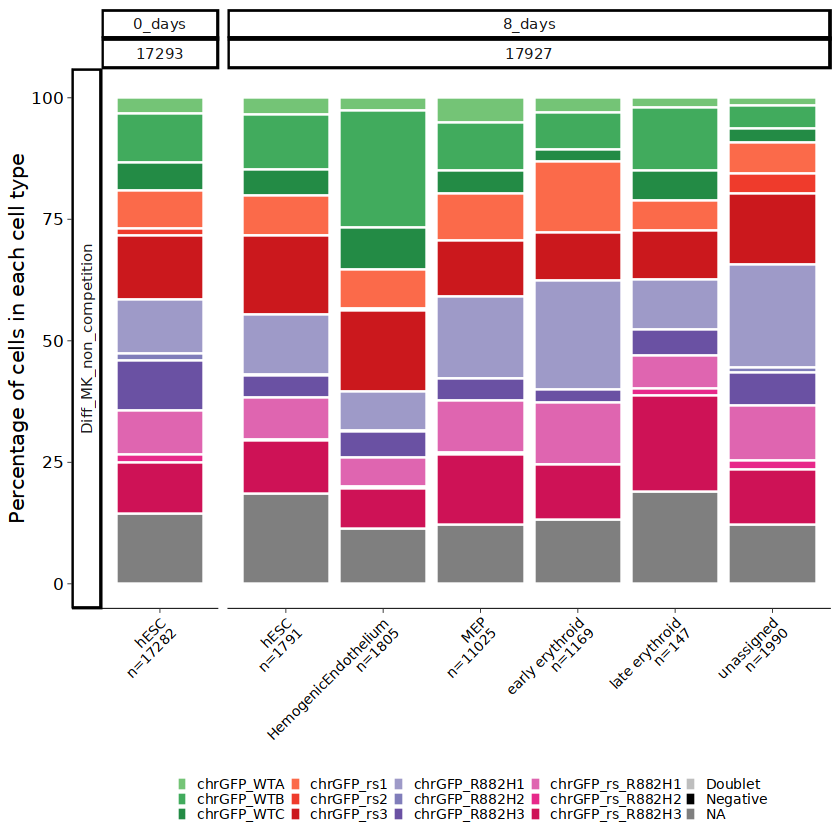

In [388]:
#### Stacked Graph #1---------------
  
  breaks.Rank<-(seq(0,100,by=25))
  labels.Rank<-as.character(breaks.Rank)
  
  cat("-------------------------------------->\t")
  cat(sprintf(as.character(labels.Rank)))
  cat("\n")
  
  
  stacked_barplot<-Freq.table_filtered %>%
    mutate(myaxis = paste0(Integrated_annotation_after_rpca, "\n", "n=", TOTAL), drop=F) %>%
    mutate(myaxis=fct_reorder(myaxis,as.numeric(Integrated_annotation_after_rpca)), drop=F) %>%
    ggplot(aes(x=myaxis, y=Perc, fill=Assignation_GEX_not_amplified)) +
    geom_bar(stat="identity",colour='white')+
    scale_y_continuous(name=paste("Percentage of cells in each cell type",sep=" "),breaks=breaks.Rank,labels=labels.Rank,
                       limits=c(breaks.Rank[1],breaks.Rank[length(breaks.Rank)]+1))+
    scale_fill_manual(values=fill_colours,
                      drop=F,
                      name="Genotype")

 stacked_barplot<-stacked_barplot+
    theme_cowplot(font_size = 2)+
    facet_grid(Diff ~ time_point+ntime, scales='free_x', space='free_x', switch="y", 
               labeller=labeller(paste0(Freq.table_filtered$time_point, "\n", "n=", Freq.table_filtered$ntime, drop=T)))+   
    scale_x_discrete(name="Integrated_annotation_after_rpca", drop=T)+
    theme( strip.background = element_blank(),
           strip.placement = "outside",
           strip.text = element_text(size=6),
           panel.spacing = unit(0.2, "lines"),
           panel.background=element_rect(fill="white"),
           panel.border=element_rect(colour="white",size=0,5),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())+
        theme_classic()+
            theme(axis.title.y=element_text(size=12, color="black", family="sans"),
                  axis.title.x=element_blank(),
                  axis.text.y=element_text(angle=0,size=10, color="black", family="sans"),
                  axis.text.x=element_text(angle=45,size=8,hjust=1,color="black", family="sans"),
                  axis.line.x = element_line(size = 0.2),
                  axis.ticks.x = element_line(size = 0.2),
                  axis.ticks.y = element_line(size = 0.2),
                  axis.line.y = element_line(size = 0.2))+
            theme(legend.title = element_blank(),
                  legend.text = element_text(size=8, color="black", family="sans"),
                  legend.key.size = unit(0.25, 'cm'), #change legend key size
                  legend.key.height = unit(0.25, 'cm'), #change legend key height
                  legend.key.width = unit(0.25, 'cm'), #change legend key width
                  legend.position="bottom")



stacked_barplot

In [389]:
path_graphs

[1] "/group/soranzo/manuel.tardaguila/2025_hESC_MK_SCRNAseq_10X/no_competition/Genotyping/graphs/"

In [390]:
setwd(path_graphs)

svgname<-paste("stacked_barplot_Diff_vs_time_point_Integrated_annotation_after_rpca_vs_Assignation_GEX_not_amplified",".png",sep='')
makesvg = TRUE

if (makesvg == TRUE)
{
  ggsave(svgname, plot= stacked_barplot,
         device="png")
}

Saving 6.67 x 6.67 in image


## Assigned_GFPbc_demux__NO_CellBender vs Integrated_annotation_after_rpca vs time_point vs Diff

In [391]:
met<-adata[[]]

In [392]:
colnames(met)

[1] "orig.ident"                          
 [2] "nCount_RNA"                          
 [3] "nFeature_RNA"                        
 [4] "nCount_RNA_raw"                      
 [5] "nFeature_RNA_raw"                    
 [6] "percent.mt"                          
 [7] "scDblFinder.class"                   
 [8] "scDblFinder.score"                   
 [9] "scDblFinder.weighted"                
[10] "scDblFinder.cxds_score"              
[11] "Diff"                                
[12] "nCount_SCT"                          
[13] "nFeature_SCT"                        
[14] "SCT_snn_res.2"                       
[15] "seurat_clusters"                     
[16] "SCT_snn_res.0.5"                     
[17] "CellTypist_label_Alsinet"            
[18] "CellTypist_conf_score_Alsinet"       
[19] "CellTypist_label_FBMA"               
[20] "CellTypist_conf_score_FBMA"          
[21] "CellTypist_label_Immune_ALL_low"     
[22] "CellTypist_conf_score_Immune_ALL_low"
[23] "Integrated_annotation"               
[24] "integrated_nn_res.0.5"               
[25] "Subclusters_2"                       
[26] "Subclusters_5"                       
[27] "Subclusters_7"                       
[28] "Subclusters_9"                       
[29] "Subclusters_10"                      
[30] "Subclusters_11"                      
[31] "Subclusters_13"                      
[32] "my_own_clusters"                     
[33] "Integrated_annotation_after_rpca"    
[34] "Assignation_demux_NO_CellBender"     
[35] "Assigned_GFPbc_demux__NO_CellBender" 
[36] "Assignation_demux_CellBender"        
[37] "Assigned_GFPbc_demux_CellBender"     
[38] "Assignation_GEX_not_amplified"       
[39] "time_point"                          
[40] "integrative_genotyping"              
[41] "clone_line"                          
[42] "Genotype"

In [393]:
met.dt<-data.table(met,key=c("time_point","Integrated_annotation_after_rpca","Assigned_GFPbc_demux__NO_CellBender","Diff"))

In [394]:
#str(met.dt)

In [395]:
Freq.table<-as.data.frame(met.dt[,.(Freq=.N),by=key(met.dt)], stringsAsFactors=F)

str(Freq.table)

'data.frame':	91 obs. of  5 variables:
 $ time_point                         : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca   : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_demux__NO_CellBender: Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Diff                               : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Freq                               : int  46 40 68 44 40 42 28 61 72 41 ...


In [396]:
met.dt<-data.table(met, key=c("time_point","Integrated_annotation_after_rpca","Diff"))
Freq.TOTAL<-as.data.frame(met.dt[,.(TOTAL=.N),by=key(met.dt)], stringsAsFactors=F)

str(Freq.TOTAL)

'data.frame':	8 obs. of  4 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 2 2 2 2 2 2
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 3 1 2 3 4 5 6
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1
 $ TOTAL                           : int  17282 11 1791 1805 11025 1169 147 1990


In [397]:
Freq.table<-merge(Freq.table,
                  Freq.TOTAL,
                  by=c("time_point","Integrated_annotation_after_rpca","Diff"))
Freq.table$Perc<-round((100*(Freq.table$Freq/Freq.table$TOTAL)),2)

#Freq.table

In [398]:
str(Freq.table)

'data.frame':	91 obs. of  7 variables:
 $ time_point                         : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca   : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                               : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_demux__NO_CellBender: Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                               : int  46 40 68 44 40 42 28 61 72 41 ...
 $ TOTAL                              : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                               : num  0.27 0.23 0.39 0.25 0.23 0.24 0.16 0.35 0.42 0.24 ...


In [399]:
met.dt<-data.table(met, key=c("time_point","Diff"))
Freq.time_point<-as.data.frame(met.dt[,.(ntime=.N),by=key(met.dt)], stringsAsFactors=F)


str(Freq.time_point)

'data.frame':	2 obs. of  3 variables:
 $ time_point: Ord.factor w/ 2 levels "0_days"<"8_days": 1 2
 $ Diff      : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1
 $ ntime     : int  17293 17927


In [400]:
Freq.table<-merge(Freq.table,
                  Freq.time_point,
                  by=c("time_point","Diff"))

str(Freq.table)

'data.frame':	91 obs. of  8 variables:
 $ time_point                         : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                               : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca   : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_demux__NO_CellBender: Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                               : int  46 40 68 44 40 42 28 61 72 41 ...
 $ TOTAL                              : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                               : num  0.27 0.23 0.39 0.25 0.23 0.24 0.16 0.35 0.42 0.24 ...
 $ ntime                              : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


In [401]:
Freq.table_filtered<-Freq.table[which(Freq.table$TOTAL >= 100),]

str(Freq.table_filtered)

'data.frame':	90 obs. of  8 variables:
 $ time_point                         : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                               : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca   : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_demux__NO_CellBender: Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                               : int  46 40 68 44 40 42 28 61 72 41 ...
 $ TOTAL                              : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                               : num  0.27 0.23 0.39 0.25 0.23 0.24 0.16 0.35 0.42 0.24 ...
 $ ntime                              : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


In [402]:
fill_colours<-c(brewer.pal(9, "Greens")[c(5,6,7)],brewer.pal(9, "Reds")[c(5,6,7)],brewer.pal(9, "Purples")[c(5,6,7)],brewer.pal(9, "PuRd")[c(5,6,7)],'gray','black')

In [403]:
str(Freq.table_filtered)

'data.frame':	90 obs. of  8 variables:
 $ time_point                         : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                               : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca   : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_demux__NO_CellBender: Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                               : int  46 40 68 44 40 42 28 61 72 41 ...
 $ TOTAL                              : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                               : num  0.27 0.23 0.39 0.25 0.23 0.24 0.16 0.35 0.42 0.24 ...
 $ ntime                              : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


-------------------------------------->	0 25 50 75 100


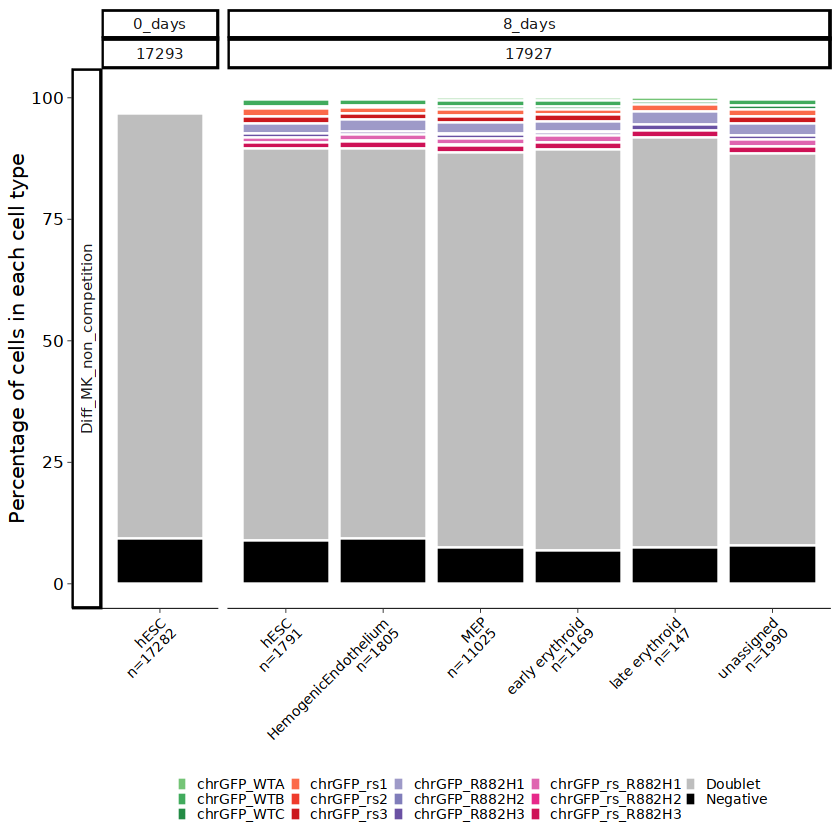

In [404]:
#### Stacked Graph #1---------------
  
  breaks.Rank<-(seq(0,100,by=25))
  labels.Rank<-as.character(breaks.Rank)
  
  cat("-------------------------------------->\t")
  cat(sprintf(as.character(labels.Rank)))
  cat("\n")
  
  
  stacked_barplot<-Freq.table_filtered %>%
    mutate(myaxis = paste0(Integrated_annotation_after_rpca, "\n", "n=", TOTAL), drop=F) %>%
    mutate(myaxis=fct_reorder(myaxis,as.numeric(Integrated_annotation_after_rpca)), drop=F) %>%
    ggplot(aes(x=myaxis, y=Perc, fill=Assigned_GFPbc_demux__NO_CellBender)) +
    geom_bar(stat="identity",colour='white')+
    scale_y_continuous(name=paste("Percentage of cells in each cell type",sep=" "),breaks=breaks.Rank,labels=labels.Rank,
                       limits=c(breaks.Rank[1],breaks.Rank[length(breaks.Rank)]+1))+
    scale_fill_manual(values=fill_colours,
                      drop=F,
                      name="Genotype")

 stacked_barplot<-stacked_barplot+
    theme_cowplot(font_size = 2)+
    facet_grid(Diff ~ time_point+ntime, scales='free_x', space='free_x', switch="y", 
               labeller=labeller(paste0(Freq.table_filtered$time_point, "\n", "n=", Freq.table_filtered$ntime, drop=T)))+   
    scale_x_discrete(name="Integrated_annotation_after_rpca", drop=T)+
    theme( strip.background = element_blank(),
           strip.placement = "outside",
           strip.text = element_text(size=6),
           panel.spacing = unit(0.2, "lines"),
           panel.background=element_rect(fill="white"),
           panel.border=element_rect(colour="white",size=0,5),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())+
        theme_classic()+
            theme(axis.title.y=element_text(size=12, color="black", family="sans"),
                  axis.title.x=element_blank(),
                  axis.text.y=element_text(angle=0,size=10, color="black", family="sans"),
                  axis.text.x=element_text(angle=45,size=8,hjust=1,color="black", family="sans"),
                  axis.line.x = element_line(size = 0.2),
                  axis.ticks.x = element_line(size = 0.2),
                  axis.ticks.y = element_line(size = 0.2),
                  axis.line.y = element_line(size = 0.2))+
            theme(legend.title = element_blank(),
                  legend.text = element_text(size=8, color="black", family="sans"),
                  legend.key.size = unit(0.25, 'cm'), #change legend key size
                  legend.key.height = unit(0.25, 'cm'), #change legend key height
                  legend.key.width = unit(0.25, 'cm'), #change legend key width
                  legend.position="bottom")



stacked_barplot

In [408]:
setwd(path_graphs)

svgname<-paste("stacked_barplot_Diff_vs_time_point_Integrated_annotation_after_rpca_vs_Assigned_GFPbc_demux__NO_CellBender",".png",sep='')
makesvg = TRUE

if (makesvg == TRUE)
{
  ggsave(svgname, plot= stacked_barplot,
         device="png")
}

Saving 6.67 x 6.67 in image


## Assigned_GFPbc_demux_CellBender vs Integrated_annotation_after_rpca vs time_point vs Diff

In [409]:
met<-adata[[]]

In [410]:
#colnames(met)

In [411]:
met.dt<-data.table(met,key=c("time_point","Integrated_annotation_after_rpca","Assigned_GFPbc_demux_CellBender","Diff"))

In [412]:
#str(met.dt)

In [413]:
Freq.table<-as.data.frame(met.dt[,.(Freq=.N),by=key(met.dt)], stringsAsFactors=F)

str(Freq.table)

'data.frame':	82 obs. of  5 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_demux_CellBender : Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Freq                            : int  26 68 47 45 25 56 41 49 59 47 ...


In [414]:
met.dt<-data.table(met, key=c("time_point","Integrated_annotation_after_rpca","Diff"))
Freq.TOTAL<-as.data.frame(met.dt[,.(TOTAL=.N),by=key(met.dt)], stringsAsFactors=F)

str(Freq.TOTAL)

'data.frame':	8 obs. of  4 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 2 2 2 2 2 2
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 3 1 2 3 4 5 6
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1
 $ TOTAL                           : int  17282 11 1791 1805 11025 1169 147 1990


In [415]:
Freq.table<-merge(Freq.table,
                  Freq.TOTAL,
                  by=c("time_point","Integrated_annotation_after_rpca","Diff"))
Freq.table$Perc<-round((100*(Freq.table$Freq/Freq.table$TOTAL)),2)

#Freq.table

In [416]:
str(Freq.table)

'data.frame':	82 obs. of  7 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_demux_CellBender : Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                            : int  26 68 47 45 25 56 41 49 59 47 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  0.15 0.39 0.27 0.26 0.14 0.32 0.24 0.28 0.34 0.27 ...


In [417]:
met.dt<-data.table(met, key=c("time_point","Diff"))
Freq.time_point<-as.data.frame(met.dt[,.(ntime=.N),by=key(met.dt)], stringsAsFactors=F)


str(Freq.time_point)

'data.frame':	2 obs. of  3 variables:
 $ time_point: Ord.factor w/ 2 levels "0_days"<"8_days": 1 2
 $ Diff      : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1
 $ ntime     : int  17293 17927


In [418]:
Freq.table<-merge(Freq.table,
                  Freq.time_point,
                  by=c("time_point","Diff"))

str(Freq.table)

'data.frame':	82 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_demux_CellBender : Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                            : int  26 68 47 45 25 56 41 49 59 47 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  0.15 0.39 0.27 0.26 0.14 0.32 0.24 0.28 0.34 0.27 ...
 $ ntime                           : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


In [419]:
Freq.table_filtered<-Freq.table[which(Freq.table$TOTAL >= 100),]

str(Freq.table_filtered)

'data.frame':	81 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_demux_CellBender : Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                            : int  26 68 47 45 25 56 41 49 59 47 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  0.15 0.39 0.27 0.26 0.14 0.32 0.24 0.28 0.34 0.27 ...
 $ ntime                           : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


In [420]:
fill_colours<-c(brewer.pal(9, "Greens")[c(5,6,7)],brewer.pal(9, "Reds")[c(5,6,7)],brewer.pal(9, "Purples")[c(5,6,7)],brewer.pal(9, "PuRd")[c(5,6,7)],'gray','black')

In [421]:
str(Freq.table_filtered)

'data.frame':	81 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_demux_CellBender : Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                            : int  26 68 47 45 25 56 41 49 59 47 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  0.15 0.39 0.27 0.26 0.14 0.32 0.24 0.28 0.34 0.27 ...
 $ ntime                           : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


-------------------------------------->	0 25 50 75 100


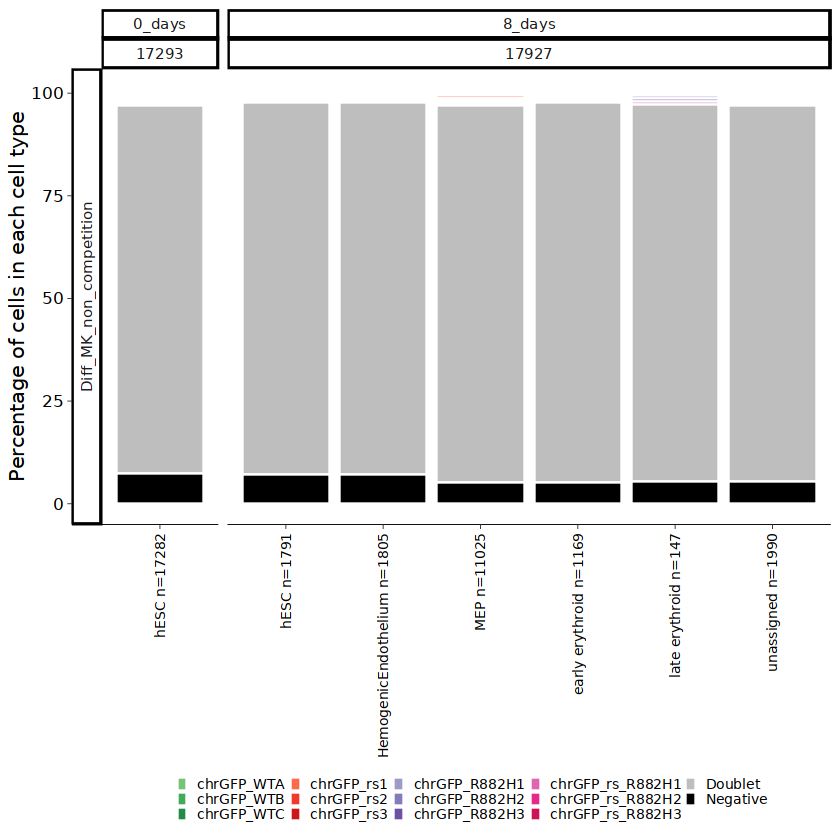

In [422]:
#### Stacked Graph #1---------------
  
  breaks.Rank<-(seq(0,100,by=25))
  labels.Rank<-as.character(breaks.Rank)
  
  cat("-------------------------------------->\t")
  cat(sprintf(as.character(labels.Rank)))
  cat("\n")
  
  
  stacked_barplot<-Freq.table_filtered %>%
    mutate(myaxis = paste0(Integrated_annotation_after_rpca, " ", "n=", TOTAL), drop=F) %>%
    mutate(myaxis=fct_reorder(myaxis,as.numeric(Integrated_annotation_after_rpca)), drop=F) %>%
    ggplot(aes(x=myaxis, y=Perc, fill=Assigned_GFPbc_demux_CellBender)) +
    geom_bar(stat="identity",colour='white')+
    scale_y_continuous(name=paste("Percentage of cells in each cell type",sep=" "),breaks=breaks.Rank,labels=labels.Rank,
                       limits=c(breaks.Rank[1],breaks.Rank[length(breaks.Rank)]+1))+
    scale_fill_manual(values=fill_colours,
                      drop=F,
                      name="Genotype")

 stacked_barplot<-stacked_barplot+
    theme_cowplot(font_size = 2)+
    facet_grid(Diff ~ time_point+ntime, scales='free_x', space='free_x', switch="y", 
               labeller=labeller(paste0(Freq.table_filtered$time_point, "\n", "n=", Freq.table_filtered$ntime, drop=T)))+   
    scale_x_discrete(name="Integrated_annotation_after_rpca", drop=T)+
    theme( strip.background = element_blank(),
           strip.placement = "outside",
           strip.text = element_text(size=6),
           panel.spacing = unit(0.2, "lines"),
           panel.background=element_rect(fill="white"),
           panel.border=element_rect(colour="white",size=0,5),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())+
        theme_classic()+
            theme(axis.title.y=element_text(size=12, color="black", family="sans"),
                  axis.title.x=element_blank(),
                  axis.text.y=element_text(angle=0,size=10, color="black", family="sans"),
                  axis.text.x=element_text(angle=90,size=8,hjust=1,vjust=0.5,color="black", family="sans"),
                  axis.line.x = element_line(size = 0.2),
                  axis.ticks.x = element_line(size = 0.2),
                  axis.ticks.y = element_line(size = 0.2),
                  axis.line.y = element_line(size = 0.2))+
            theme(legend.title = element_blank(),
                  legend.text = element_text(size=8, color="black", family="sans"),
                  legend.key.size = unit(0.25, 'cm'), #change legend key size
                  legend.key.height = unit(0.25, 'cm'), #change legend key height
                  legend.key.width = unit(0.25, 'cm'), #change legend key width
                  legend.position="bottom")



stacked_barplot

In [423]:
setwd(path_graphs)

svgname<-paste("stacked_barplot_Diff_vs_time_point_Integrated_annotation_after_rpca_vs_Assigned_GFPbc_demux_CellBender",".png",sep='')
makesvg = TRUE

if (makesvg == TRUE)
{
  ggsave(svgname, plot= stacked_barplot,
         device="png")
}

Saving 6.67 x 6.67 in image


# Create an integrative genotype assignation

In [424]:
adata@meta.data$integrative_genotyping<-NA

In [425]:
summary(as.factor(adata@meta.data$integrative_genotyping))

NA's 
35220

## 1. First keep the genotype assignation from the GEX library using Paola's criteria (3 UMIs and no conflicting barcodes)

In [426]:
indx.keep<-!is.na(adata@meta.data$Assignation_GEX_not_amplified)

str(indx.keep)

indx.change<-is.na(adata@meta.data$Assignation_GEX_not_amplified)

str(indx.change)

 logi [1:35220] TRUE TRUE TRUE TRUE TRUE TRUE ...
 logi [1:35220] FALSE FALSE FALSE FALSE FALSE FALSE ...


In [427]:
adata@meta.data$integrative_genotyping[indx.keep]<-as.character(adata@meta.data$Assignation_GEX_not_amplified[indx.keep])

In [428]:
summary(as.factor(adata@meta.data$integrative_genotyping))

chrGFP_R882H1    chrGFP_R882H2    chrGFP_R882H3 chrGFP_rs_R882H1 
            4847              271             2619             3404 
chrGFP_rs_R882H2 chrGFP_rs_R882H3       chrGFP_rs1       chrGFP_rs2 
             379             4141             3001              342 
      chrGFP_rs3       chrGFP_WTA       chrGFP_WTB       chrGFP_WTC 
            4577             1294             3683             1864 
            NA's 
            4798

## 2. Inside the 'Genotype missing' use the targeted amplification data. For the targeted amplification library use the assignation of Demux without CellBender except for the Doublets label

In [429]:
str(adata@meta.data$integrative_genotyping)
cat("\n")

str(adata@meta.data$Assigned_GFPbc_demux__NO_CellBender)
cat("\n")

 chr [1:35220] "chrGFP_rs_R882H1" "chrGFP_WTB" "chrGFP_R882H1" ...

 Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 14 13 14 13 13 13 1 14 13 14 ...



In [430]:
indx.keep.2<-is.na(adata@meta.data$integrative_genotyping) & adata@meta.data$Assigned_GFPbc_demux__NO_CellBender != 'Doublet'

str(indx.keep.2)

sum(indx.keep.2)

 logi [1:35220] FALSE FALSE FALSE FALSE FALSE FALSE ...


[1] 1156

In [431]:
indx.change.2<-is.na(adata@meta.data$integrative_genotyping) & adata@meta.data$Assigned_GFPbc_demux__NO_CellBender == 'Doublet'

str(indx.change.2)

sum(indx.change.2)

 logi [1:35220] FALSE FALSE FALSE FALSE FALSE FALSE ...


[1] 3642

In [432]:
adata@meta.data$integrative_genotyping[indx.keep.2]<-as.character(adata@meta.data$Assigned_GFPbc_demux__NO_CellBender[indx.keep.2])

## 3 Inside the 'Doublet' use the Cell Bender correction

In [433]:
adata@meta.data$integrative_genotyping[indx.change.2]<-as.character(adata@meta.data$Assigned_GFPbc_demux_CellBender[indx.change.2])

In [434]:
length(indx.keep)+length(indx.keep.2)+length(indx.change.2)

[1] 105660

In [435]:
dim(adata@meta.data)[1]

[1] 35220

## Order the factor

In [436]:
summary(as.factor(adata@meta.data$integrative_genotyping))

chrGFP_R882H1    chrGFP_R882H2    chrGFP_R882H3 chrGFP_rs_R882H1 
            4902              286             2642             3434 
chrGFP_rs_R882H2 chrGFP_rs_R882H3       chrGFP_rs1       chrGFP_rs2 
             390             4173             3043              357 
      chrGFP_rs3       chrGFP_WTA       chrGFP_WTB       chrGFP_WTC 
            4602             1314             3724             1889 
         Doublet         Negative 
            3642              822

In [437]:
#summary(droplevels(as.factor(adata@meta.data$Assigned_GFPbc[is.na(adata@meta.data$integrative_genotyping)])))

In [438]:
#summary(droplevels(as.factor(adata@meta.data$Assigned_GFPbc_demux__NO_CellBender[is.na(adata@meta.data$integrative_genotyping)])))

In [439]:
#summary(droplevels(as.factor(adata@meta.data$Assigned_GFPbc_demux_CellBender[is.na(adata@meta.data$integrative_genotyping)])))

In [440]:
adata@meta.data$integrative_genotyping<-factor(adata@meta.data$integrative_genotyping,
                                       levels = c("chrGFP_WTA","chrGFP_WTB","chrGFP_WTC",
                                                  "chrGFP_rs1","chrGFP_rs2","chrGFP_rs3",
                                                  "chrGFP_R882H1","chrGFP_R882H2","chrGFP_R882H3",
                                                  "chrGFP_rs_R882H1","chrGFP_rs_R882H2","chrGFP_rs_R882H3","Doublet","Negative"),
                                       ordered=T)

In [441]:
summary(adata@meta.data$integrative_genotyping)

chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
            1314             3724             1889             3043 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
             357             4602             4902              286 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
            2642             3434              390             4173 
         Doublet         Negative 
            3642              822

# Create the clone line factor and order it

In [442]:
adata@meta.data$clone_line<-adata@meta.data$integrative_genotyping

In [443]:
suppressMessages(library("plyr"))

In [444]:
adata@meta.data$clone_line<-revalue(adata@meta.data$clone_line,
                                   c('chrGFP_WTA' = 'wt_1',
                                    'chrGFP_WTB' = 'wt_2',
                                     'chrGFP_WTC' = 'wt_3',
                                    'chrGFP_rs1' = 'rs62237617_1',
                                     'chrGFP_rs2' = 'rs62237617_2',
                                     'chrGFP_rs3' = 'rs62237617_3',
                                     'chrGFP_R882H1' = 'DNMT3A_1',
                                     'chrGFP_R882H2' = 'DNMT3A_2',
                                     'chrGFP_R882H3' = 'DNMT3A_3',
                                     'chrGFP_rs_R882H1' = 'rs62237617_DNMT3A_1',
                                     'chrGFP_rs_R882H2' = 'rs62237617_DNMT3A_2',
                                     'chrGFP_rs_R882H3' = 'rs62237617_DNMT3A_3') 
                                   )

In [445]:
summary(adata@meta.data$clone_line)

wt_1                wt_2                wt_3        rs62237617_1 
               1314                3724                1889                3043 
       rs62237617_2        rs62237617_3            DNMT3A_1            DNMT3A_2 
                357                4602                4902                 286 
           DNMT3A_3 rs62237617_DNMT3A_1 rs62237617_DNMT3A_2 rs62237617_DNMT3A_3 
               2642                3434                 390                4173 
            Doublet            Negative 
               3642                 822

In [446]:
adata@meta.data$clone_line<-factor(adata@meta.data$clone_line,
                                  levels=c('wt_1','wt_2','wt_3','rs62237617_1','rs62237617_2','rs62237617_3',
                                           'DNMT3A_1','DNMT3A_2','DNMT3A_3',
                                          'rs62237617_DNMT3A_1','rs62237617_DNMT3A_2','rs62237617_DNMT3A_3'),
                                  ordered=T)

In [447]:
summary(adata@meta.data$clone_line)

wt_1                wt_2                wt_3        rs62237617_1 
               1314                3724                1889                3043 
       rs62237617_2        rs62237617_3            DNMT3A_1            DNMT3A_2 
                357                4602                4902                 286 
           DNMT3A_3 rs62237617_DNMT3A_1 rs62237617_DNMT3A_2 rs62237617_DNMT3A_3 
               2642                3434                 390                4173 
               NA's 
               4464

# Add the genotype factor

In [448]:
  
  adata@meta.data$Genotype<-NA
  
  adata@meta.data$Genotype[which(adata@meta.data$clone_line%in%c('wt_1','wt_2','wt_3'))]<-'wt'
  adata@meta.data$Genotype[which(adata@meta.data$clone_line%in%c('rs62237617_1','rs62237617_2','rs62237617_3'))]<-'rs62237617'
  adata@meta.data$Genotype[which(adata@meta.data$clone_line%in%c('DNMT3A_1','DNMT3A_2','DNMT3A_3'))]<-'DNMT3A'
  adata@meta.data$Genotype[which(adata@meta.data$clone_line%in%c('rs62237617_DNMT3A_1','rs62237617_DNMT3A_2','rs62237617_DNMT3A_3'))]<-'rs62237617_DNMT3A'
  
  
  cat("adata@meta.data_PRE\n")
  #cat(str(adata@meta.data))
  cat("\n")
  names(summary(as.factor(adata@meta.data$Genotype)))
  cat("\n")
  names(summary(as.factor(adata@meta.data$clone_line)))
  cat("\n")
   
  
  
  adata@meta.data$Genotype<-factor(adata@meta.data$Genotype,
                                  levels=c('wt','rs62237617','DNMT3A','rs62237617_DNMT3A'),
                                  ordered=T)

summary(as.factor(adata@meta.data$Genotype))
  cat("\n")

adata@meta.data_PRE



[1] "DNMT3A"            "rs62237617"        "rs62237617_DNMT3A"
[4] "wt"                "NA's"

[1] "wt_1"                "wt_2"                "wt_3"               
 [4] "rs62237617_1"        "rs62237617_2"        "rs62237617_3"       
 [7] "DNMT3A_1"            "DNMT3A_2"            "DNMT3A_3"           
[10] "rs62237617_DNMT3A_1" "rs62237617_DNMT3A_2" "rs62237617_DNMT3A_3"
[13] "NA's"

wt        rs62237617            DNMT3A rs62237617_DNMT3A 
             6927              8002              7830              7997 
             NA's 
             4464

## Show the genotype breakdown new

### clone_line vs Integrated_annotation_after_rpca vs time_point vs Diff

In [449]:
met<-adata[[]]

In [450]:
#colnames(met)

In [451]:
met.dt<-data.table(met,key=c("time_point","Integrated_annotation_after_rpca","clone_line","Diff"))

In [452]:
#str(met.dt)

In [453]:
Freq.table<-as.data.frame(met.dt[,.(Freq=.N),by=key(met.dt)], stringsAsFactors=F)

str(Freq.table)

'data.frame':	94 obs. of  5 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ clone_line                      : Ord.factor w/ 12 levels "wt_1"<"wt_2"<..: NA 1 2 3 4 5 6 7 8 9 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Freq                            : int  2424 552 1769 993 1354 262 2282 1932 256 1765 ...


In [454]:
met.dt<-data.table(met, key=c("time_point","Integrated_annotation_after_rpca","Diff"))
Freq.TOTAL<-as.data.frame(met.dt[,.(TOTAL=.N),by=key(met.dt)], stringsAsFactors=F)

str(Freq.TOTAL)

'data.frame':	8 obs. of  4 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 2 2 2 2 2 2
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 3 1 2 3 4 5 6
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1
 $ TOTAL                           : int  17282 11 1791 1805 11025 1169 147 1990


In [455]:
Freq.table<-merge(Freq.table,
                  Freq.TOTAL,
                  by=c("time_point","Integrated_annotation_after_rpca","Diff"))
Freq.table$Perc<-round((100*(Freq.table$Freq/Freq.table$TOTAL)),2)

#Freq.table

In [456]:
str(Freq.table)

'data.frame':	94 obs. of  7 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ clone_line                      : Ord.factor w/ 12 levels "wt_1"<"wt_2"<..: NA 1 2 3 4 5 6 7 8 9 ...
 $ Freq                            : int  2424 552 1769 993 1354 262 2282 1932 256 1765 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  14.03 3.19 10.24 5.75 7.83 ...


In [457]:
met.dt<-data.table(met, key=c("time_point","Diff"))
Freq.time_point<-as.data.frame(met.dt[,.(ntime=.N),by=key(met.dt)], stringsAsFactors=F)


str(Freq.time_point)

'data.frame':	2 obs. of  3 variables:
 $ time_point: Ord.factor w/ 2 levels "0_days"<"8_days": 1 2
 $ Diff      : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1
 $ ntime     : int  17293 17927


In [458]:
Freq.table<-merge(Freq.table,
                  Freq.time_point,
                  by=c("time_point","Diff"))

str(Freq.table)

'data.frame':	94 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ clone_line                      : Ord.factor w/ 12 levels "wt_1"<"wt_2"<..: NA 1 2 3 4 5 6 7 8 9 ...
 $ Freq                            : int  2424 552 1769 993 1354 262 2282 1932 256 1765 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  14.03 3.19 10.24 5.75 7.83 ...
 $ ntime                           : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


In [459]:
Freq.table_filtered<-Freq.table[which(Freq.table$TOTAL >= 100),]

str(Freq.table_filtered)

'data.frame':	87 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ clone_line                      : Ord.factor w/ 12 levels "wt_1"<"wt_2"<..: NA 1 2 3 4 5 6 7 8 9 ...
 $ Freq                            : int  2424 552 1769 993 1354 262 2282 1932 256 1765 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  14.03 3.19 10.24 5.75 7.83 ...
 $ ntime                           : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


In [460]:
fill_colours<-c(brewer.pal(9, "Greens")[c(5,6,7)],brewer.pal(9, "Reds")[c(5,6,7)],brewer.pal(9, "Purples")[c(5,6,7)],brewer.pal(9, "PuRd")[c(5,6,7)],'gray','black')

In [461]:
str(Freq.table_filtered)

'data.frame':	87 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ clone_line                      : Ord.factor w/ 12 levels "wt_1"<"wt_2"<..: NA 1 2 3 4 5 6 7 8 9 ...
 $ Freq                            : int  2424 552 1769 993 1354 262 2282 1932 256 1765 ...
 $ TOTAL                           : int  17282 17282 17282 17282 17282 17282 17282 17282 17282 17282 ...
 $ Perc                            : num  14.03 3.19 10.24 5.75 7.83 ...
 $ ntime                           : int  17293 17293 17293 17293 17293 17293 17293 17293 17293 17293 ...


-------------------------------------->	0 25 50 75 100


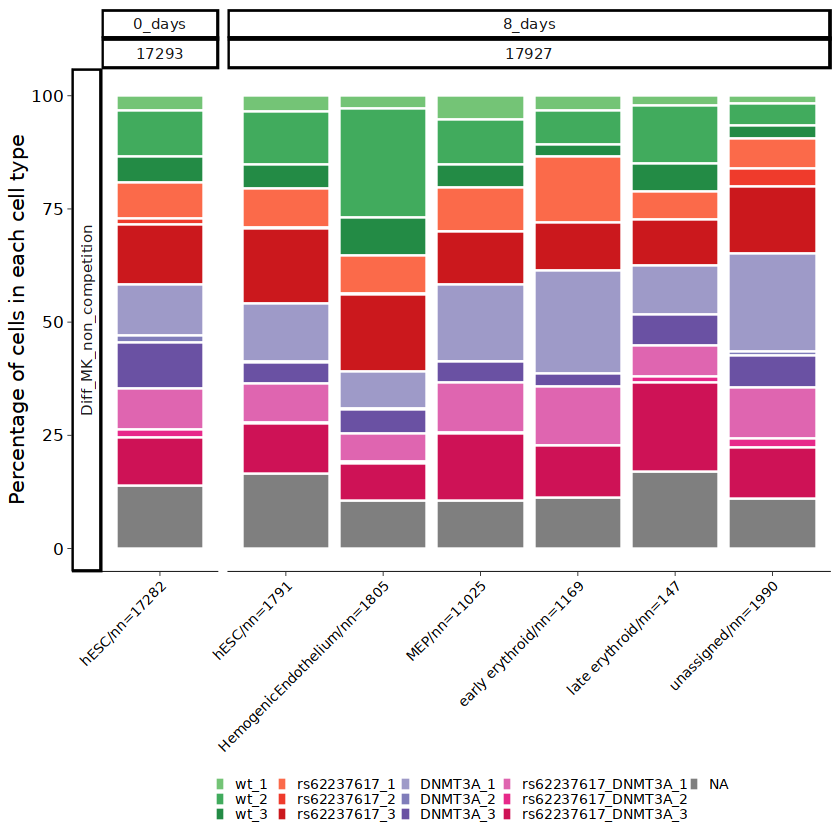

In [462]:
#### Stacked Graph #1---------------
  
  breaks.Rank<-(seq(0,100,by=25))
  labels.Rank<-as.character(breaks.Rank)
  
  cat("-------------------------------------->\t")
  cat(sprintf(as.character(labels.Rank)))
  cat("\n")
  
  
  stacked_barplot<-Freq.table_filtered %>%
    mutate(myaxis = paste0(Integrated_annotation_after_rpca, "/n", "n=", TOTAL), drop=F) %>%
    mutate(myaxis=fct_reorder(myaxis,as.numeric(Integrated_annotation_after_rpca)), drop=F) %>%
    ggplot(aes(x=myaxis, y=Perc, fill=clone_line)) +
    geom_bar(stat="identity",colour='white')+
    scale_y_continuous(name=paste("Percentage of cells in each cell type",sep=" "),breaks=breaks.Rank,labels=labels.Rank,
                       limits=c(breaks.Rank[1],breaks.Rank[length(breaks.Rank)]+1))+
    scale_fill_manual(values=fill_colours,
                      drop=F,
                      name="Genotype")

 stacked_barplot<-stacked_barplot+
    theme_cowplot(font_size = 2)+
    facet_grid(Diff ~ time_point+ntime, scales='free_x', space='free_x', switch="y", 
               labeller=labeller(paste0(Freq.table_filtered$time_point, "\n", "n=", Freq.table_filtered$ntime, drop=T)))+   
    scale_x_discrete(name="Integrated_annotation_after_rpca", drop=T)+
    theme( strip.background = element_blank(),
           strip.placement = "outside",
           strip.text = element_text(size=6),
           panel.spacing = unit(0.2, "lines"),
           panel.background=element_rect(fill="white"),
           panel.border=element_rect(colour="white",size=0,5),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())+
        theme_classic()+
            theme(axis.title.y=element_text(size=12, color="black", family="sans"),
                  axis.title.x=element_blank(),
                  axis.text.y=element_text(angle=0,size=10, color="black", family="sans"),
                  axis.text.x=element_text(angle=45,size=8,hjust=1,color="black", family="sans"),
                  axis.line.x = element_line(size = 0.2),
                  axis.ticks.x = element_line(size = 0.2),
                  axis.ticks.y = element_line(size = 0.2),
                  axis.line.y = element_line(size = 0.2))+
            theme(legend.title = element_blank(),
                  legend.text = element_text(size=8, color="black", family="sans"),
                  legend.key.size = unit(0.25, 'cm'), #change legend key size
                  legend.key.height = unit(0.25, 'cm'), #change legend key height
                  legend.key.width = unit(0.25, 'cm'), #change legend key width
                  legend.position="bottom")



stacked_barplot

In [463]:
setwd(path_graphs)

svgname<-paste("stacked_barplot_Diff_vs_time_point_Integrated_annotation_after_rpca_vs_clone_line",".png",sep='')
makesvg = TRUE

if (makesvg == TRUE)
{
  ggsave(svgname, plot= stacked_barplot,
         device="png")
}

Saving 6.67 x 6.67 in image


# Subset for only genotyped cells

In [464]:
adata_sub<-subset(adata, integrative_genotyping != "Doublet" & integrative_genotyping != "Negative")
adata_sub

An object of class Seurat 
104138 features across 30756 samples within 4 assays 
Active assay: SCT (28364 features, 0 variable features)
 3 layers present: counts, data, scale.data
 3 other assays present: RNA, RNA_raw, integrated
 2 dimensional reductions calculated: pca, umap

In [465]:
met<-droplevels(adata_sub[[]])

### clone_line vs Integrated_annotation_after_rpca vs time_point vs Diff

In [466]:
met.dt<-data.table(met,key=c("time_point","Integrated_annotation_after_rpca","clone_line","Diff"))

In [467]:
#str(met.dt)

In [468]:
Freq.table<-as.data.frame(met.dt[,.(Freq=.N),by=key(met.dt)], stringsAsFactors=F)

str(Freq.table)

'data.frame':	86 obs. of  5 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ clone_line                      : Ord.factor w/ 12 levels "wt_1"<"wt_2"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Freq                            : int  552 1769 993 1354 262 2282 1932 256 1765 1576 ...


In [469]:
met.dt<-data.table(met, key=c("time_point","Integrated_annotation_after_rpca","Diff"))
Freq.TOTAL<-as.data.frame(met.dt[,.(TOTAL=.N),by=key(met.dt)], stringsAsFactors=F)

str(Freq.TOTAL)

'data.frame':	8 obs. of  4 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 2 2 2 2 2 2
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 3 1 2 3 4 5 6
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1
 $ TOTAL                           : int  14858 10 1495 1614 9849 1038 122 1770


In [470]:
Freq.table<-merge(Freq.table,
                  Freq.TOTAL,
                  by=c("time_point","Integrated_annotation_after_rpca","Diff"))
Freq.table$Perc<-round((100*(Freq.table$Freq/Freq.table$TOTAL)),2)

#Freq.table

In [471]:
str(Freq.table)

'data.frame':	86 obs. of  7 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ clone_line                      : Ord.factor w/ 12 levels "wt_1"<"wt_2"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                            : int  552 1769 993 1354 262 2282 1932 256 1765 1576 ...
 $ TOTAL                           : int  14858 14858 14858 14858 14858 14858 14858 14858 14858 14858 ...
 $ Perc                            : num  3.72 11.91 6.68 9.11 1.76 ...


In [472]:
met.dt<-data.table(met, key=c("time_point","Diff"))
Freq.time_point<-as.data.frame(met.dt[,.(ntime=.N),by=key(met.dt)], stringsAsFactors=F)


str(Freq.time_point)

'data.frame':	2 obs. of  3 variables:
 $ time_point: Ord.factor w/ 2 levels "0_days"<"8_days": 1 2
 $ Diff      : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1
 $ ntime     : int  14868 15888


In [473]:
Freq.table<-merge(Freq.table,
                  Freq.time_point,
                  by=c("time_point","Diff"))

str(Freq.table)

'data.frame':	86 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ clone_line                      : Ord.factor w/ 12 levels "wt_1"<"wt_2"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                            : int  552 1769 993 1354 262 2282 1932 256 1765 1576 ...
 $ TOTAL                           : int  14858 14858 14858 14858 14858 14858 14858 14858 14858 14858 ...
 $ Perc                            : num  3.72 11.91 6.68 9.11 1.76 ...
 $ ntime                           : int  14868 14868 14868 14868 14868 14868 14868 14868 14868 14868 ...


In [474]:
Freq.table_filtered<-Freq.table[which(Freq.table$TOTAL >= 50),]

str(Freq.table_filtered)

'data.frame':	80 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ clone_line                      : Ord.factor w/ 12 levels "wt_1"<"wt_2"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                            : int  552 1769 993 1354 262 2282 1932 256 1765 1576 ...
 $ TOTAL                           : int  14858 14858 14858 14858 14858 14858 14858 14858 14858 14858 ...
 $ Perc                            : num  3.72 11.91 6.68 9.11 1.76 ...
 $ ntime                           : int  14868 14868 14868 14868 14868 14868 14868 14868 14868 14868 ...


In [475]:
fill_colours<-c(brewer.pal(9, "Greens")[c(5,6,7)],brewer.pal(9, "Reds")[c(5,6,7)],brewer.pal(9, "Purples")[c(5,6,7)],brewer.pal(9, "PuRd")[c(5,6,7)],'gray','black')

In [476]:
str(Freq.table_filtered)

'data.frame':	80 obs. of  8 variables:
 $ time_point                      : Ord.factor w/ 2 levels "0_days"<"8_days": 1 1 1 1 1 1 1 1 1 1 ...
 $ Diff                            : Ord.factor w/ 1 level "Diff_MK_non_competition": 1 1 1 1 1 1 1 1 1 1 ...
 $ Integrated_annotation_after_rpca: Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ clone_line                      : Ord.factor w/ 12 levels "wt_1"<"wt_2"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                            : int  552 1769 993 1354 262 2282 1932 256 1765 1576 ...
 $ TOTAL                           : int  14858 14858 14858 14858 14858 14858 14858 14858 14858 14858 ...
 $ Perc                            : num  3.72 11.91 6.68 9.11 1.76 ...
 $ ntime                           : int  14868 14868 14868 14868 14868 14868 14868 14868 14868 14868 ...


-------------------------------------->	0 25 50 75 100


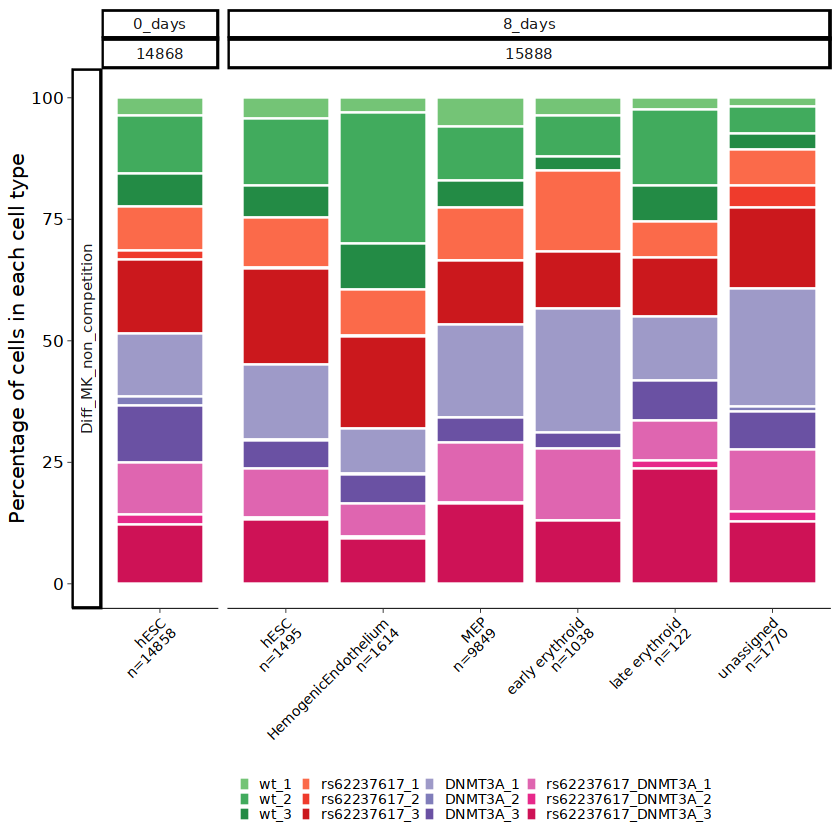

In [479]:
#### Stacked Graph #1---------------
  
  breaks.Rank<-(seq(0,100,by=25))
  labels.Rank<-as.character(breaks.Rank)
  
  cat("-------------------------------------->\t")
  cat(sprintf(as.character(labels.Rank)))
  cat("\n")
  
  
  stacked_barplot<-Freq.table_filtered %>%
    mutate(myaxis = paste0(Integrated_annotation_after_rpca, "\n", "n=", TOTAL), drop=F) %>%
    mutate(myaxis=fct_reorder(myaxis,as.numeric(Integrated_annotation_after_rpca)), drop=F) %>%
    ggplot(aes(x=myaxis, y=Perc, fill=clone_line)) +
    geom_bar(stat="identity",colour='white')+
    scale_y_continuous(name=paste("Percentage of cells in each cell type",sep=" "),breaks=breaks.Rank,labels=labels.Rank,
                       limits=c(breaks.Rank[1],breaks.Rank[length(breaks.Rank)]+1))+
    scale_fill_manual(values=fill_colours,
                      drop=F,
                      name="Genotype")

 stacked_barplot<-stacked_barplot+
    theme_cowplot(font_size = 2)+
    facet_grid(Diff ~ time_point+ntime, scales='free_x', space='free_x', switch="y", 
               labeller=labeller(paste0(Freq.table_filtered$time_point, "\n", "n=", Freq.table_filtered$ntime, drop=T)))+   
    scale_x_discrete(name="Integrated_annotation_after_rpca", drop=T)+
    theme( strip.background = element_blank(),
           strip.placement = "outside",
           strip.text = element_text(size=6),
           panel.spacing = unit(0.2, "lines"),
           panel.background=element_rect(fill="white"),
           panel.border=element_rect(colour="white",size=0,5),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())+
        theme_classic()+
            theme(axis.title.y=element_text(size=12, color="black", family="sans"),
                  axis.title.x=element_blank(),
                  axis.text.y=element_text(angle=0,size=10, color="black", family="sans"),
                  axis.text.x=element_text(angle=45,size=8,hjust=1,color="black", family="sans"),
                  axis.line.x = element_line(size = 0.2),
                  axis.ticks.x = element_line(size = 0.2),
                  axis.ticks.y = element_line(size = 0.2),
                  axis.line.y = element_line(size = 0.2))+
            theme(legend.title = element_blank(),
                  legend.text = element_text(size=8, color="black", family="sans"),
                  legend.key.size = unit(0.25, 'cm'), #change legend key size
                  legend.key.height = unit(0.25, 'cm'), #change legend key height
                  legend.key.width = unit(0.25, 'cm'), #change legend key width
                  legend.position="bottom")



stacked_barplot

In [480]:
setwd(path_graphs)

svgname<-paste("stacked_barplot_Diff_vs_time_point_Integrated_annotation_after_rpca_vs_clone_line_only_genotyped_cells",".png",sep='')
makesvg = TRUE

if (makesvg == TRUE)
{
  ggsave(svgname, plot= stacked_barplot,
         device="png")
}

Saving 6.67 x 6.67 in image


# Save the new object

In [373]:
setwd("/scratch/manuel.tardaguila/hESC_MK_SCRNAseq_10X/no_competition/processing_outputs/")

saveRDS(adata_sub, file="merged_unprocessed_db_filt_clustered_QCed_cell_annotated_rpca_integrate_clustered_subcluster_majority_vote_only_genotyped.rds")

In [374]:
setwd("/scratch/manuel.tardaguila/hESC_MK_SCRNAseq_10X/no_competition/processing_outputs/")

saveRDS(adata, file="merged_unprocessed_db_filt_clustered_QCed_cell_annotated_rpca_integrate_clustered_subcluster_majority_vote_and_genotyped.rds")